In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import pickle
import streamlit as st
import joblib


In [5]:
class DiamondPricePredictor:
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.feature_selectors = {}
        self.encoders = {}
        
    def load_and_explore_data(self, filepath):
        
        # Load data
        self.df = pd.read_csv(filepath)
        
        # Basic information
        print("Dataset Info:")
        print(self.df.info())
        
        # Summary statistics
        print("\nSummary Statistics:")
        print(self.df.describe())
        
        # Missing values analysis
        print("\nMissing Values:")
        print(self.df.isnull().sum())
        
        # Data visualization
        self.plot_exploratory_analysis()
        
        return self.df
    
    def plot_exploratory_analysis(self):

        # Distribution of price
        plt.figure(figsize=(10, 6))
        sns.histplot(self.df['Price'])
        plt.title('Distribution of Diamond Prices')
        plt.show()
        
        # Correlation matrix
        plt.figure(figsize=(12, 8))
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        sns.heatmap(self.df[numeric_cols].corr(), annot=True)
        plt.title('Correlation Matrix')
        plt.show()
        
        # Box plots for categorical variables
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=col, y='Price', data=self.df)
            plt.xticks(rotation=45)
            plt.title(f'Price Distribution by {col}')
            plt.show()
    
    def preprocess_data(self):

        # Handle missing values
        for col in self.df.columns:
            if self.df[col].isnull().sum() > 0:
                if self.df[col].dtype in ['int64', 'float64']:
                    self.df[col].fillna(self.df[col].mean(), inplace=True)
                else:
                    self.df[col].fillna(self.df[col].mode()[0], inplace=True)
        
        # Encode categorical variables
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            self.encoders[col] = LabelEncoder()
            self.df[col] = self.encoders[col].fit_transform(self.df[col])
        
        # Feature engineering
        self.df['Volume'] = self.df['Length'] * self.df['Width'] * self.df['Height']
        self.df['Price_per_carat'] = self.df['Price'] / self.df['Carat Weight']
        
        # Prepare features and target
        self.features = self.df.drop(['Price'], axis=1)
        self.target = self.df['Price']
        
        return self.features, self.target
    
    def perform_feature_selection(self, k=10):

        # Select K best features
        self.feature_selector = SelectKBest(score_func=f_regression, k=k)
        self.features_selected = self.feature_selector.fit_transform(self.features, self.target)
        
        # Get selected feature names
        selected_features_mask = self.feature_selector.get_support()
        self.selected_feature_names = self.features.columns[selected_features_mask]
        
        print("Selected features:", self.selected_feature_names)
        return self.features_selected
    
    def train_models(self):

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.features_selected, self.target, test_size=0.2, random_state=42
        )
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Define models with hyperparameter grids
        models_config = {
            'Linear Regression': {
                'model': LinearRegression(),
                'params': {}
            },
            'Random Forest': {
                'model': RandomForestRegressor(),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [10, 20, None]
                }
            },
            'XGBoost': {
                'model': XGBRegressor(),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [3, 5, 7]
                }
            },
            'SVR': {
                'model': SVR(),
                'params': {
                    'kernel': ['rbf', 'linear'],
                    'C': [1, 10]
                }
            },
            'KNN': {
                'model': KNeighborsRegressor(),
                'params': {
                    'n_neighbors': [3, 5, 7],
                    'weights': ['uniform', 'distance']
                }
            }
        }
        
        # Train and tune each model
        self.results = {}
        for name, config in models_config.items():
            print(f"\nTraining {name}...")
            
            # Perform grid search if parameters exist
            if config['params']:
                grid_search = GridSearchCV(
                    config['model'],
                    config['params'],
                    cv=5,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1
                )
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_
                print(f"Best parameters: {grid_search.best_params_}")
            else:
                best_model = config['model']
                best_model.fit(X_train_scaled, y_train)
            
            # Store model
            self.models[name] = best_model
            
            # Make predictions
            y_pred = best_model.predict(X_test_scaled)
            
            # Calculate metrics
            self.results[name] = {
                'R2 Score': r2_score(y_test, y_pred),
                'MSE': mean_squared_error(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred)
            }
        
        return self.results
    
    def evaluate_models(self):

        # Plot performance comparison
        plt.figure(figsize=(12, 6))
        metrics = ['R2 Score', 'MSE', 'RMSE', 'MAE']
        
        for i, metric in enumerate(metrics, 1):
            plt.subplot(2, 2, i)
            values = [results[metric] for results in self.results.values()]
            plt.bar(self.results.keys(), values)
            plt.title(f'Model Comparison - {metric}')
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance analysis (for Random Forest)
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']
            feature_importance = pd.DataFrame({
                'feature': self.selected_feature_names,
                'importance': rf_model.feature_importances_
            })
            feature_importance = feature_importance.sort_values('importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=feature_importance)
            plt.title('Feature Importance (Random Forest)')
            plt.show()
    
    def save_models(self, path='models/'):

        import os
        if not os.path.exists(path):
            os.makedirs(path)
            
        # Save models
        for name, model in self.models.items():
            joblib.dump(model, f'{path}{name.lower().replace(" ", "_")}.pkl')
        
        # Save preprocessing objects
        joblib.dump(self.scaler, f'{path}scaler.pkl')
        joblib.dump(self.feature_selector, f'{path}feature_selector.pkl')
        joblib.dump(self.encoders, f'{path}encoders.pkl')
        
    def create_web_app(self):

        def run_app():
            st.title('Diamond Price Predictor')
            
            # Input form
            st.header('Enter Diamond Characteristics')
            
            carat = st.number_input('Carat Weight', min_value=0.1, max_value=10.0, value=1.0)
            cut = st.selectbox('Cut', ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
            color = st.selectbox('Color', ['D', 'E', 'F', 'G', 'H', 'I', 'J'])
            clarity = st.selectbox('Clarity', ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'])
            
            if st.button('Predict Price'):
                # Prepare input data
                input_data = pd.DataFrame({
                    'Carat Weight': [carat],
                    'Cut': [cut],
                    'Color': [color],
                    'Clarity': [clarity]
                })
                
                # Preprocess input
                for col in input_data.columns:
                    if col in self.encoders:
                        input_data[col] = self.encoders[col].transform(input_data[col])
                
                # Scale input
                input_scaled = self.scaler.transform(input_data)
                
                # Make predictions with all models
                predictions = {}
                for name, model in self.models.items():
                    predictions[name] = model.predict(input_scaled)[0]
                
                # Display predictions
                st.header('Price Predictions')
                for name, pred in predictions.items():
                    st.write(f"{name}: ${pred:,.2f}")
        
        # Run the app
        if st.runtime.exists():
            run_app()


In [9]:
# Initialize predictor
predictor = DiamondPricePredictor()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6485 entries, 0 to 6484
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Shape               6480 non-null   object 
 1   Cut                 2182 non-null   object 
 2   Color               6480 non-null   object 
 3   Clarity             6480 non-null   object 
 4   Carat Weight        6480 non-null   float64
 5   Length/Width Ratio  6480 non-null   float64
 6   Depth %             6478 non-null   float64
 7   Table %             6468 non-null   float64
 8   Polish              6465 non-null   object 
 9   Symmetry            6465 non-null   object 
 10  Girdle              6463 non-null   object 
 11  Culet               1891 non-null   object 
 12  Length              6465 non-null   float64
 13  Width               6465 non-null   float64
 14  Height              6465 non-null   float64
 15  Price               6485 non-null   int64

F:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


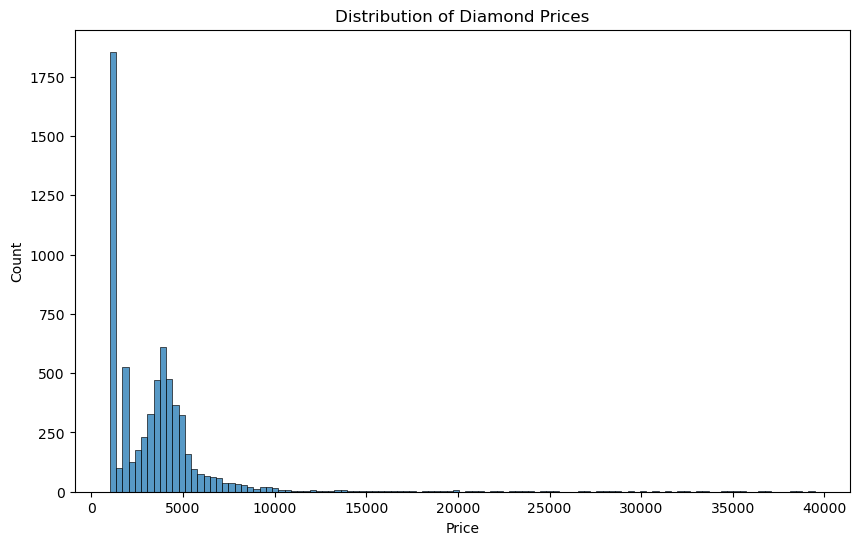

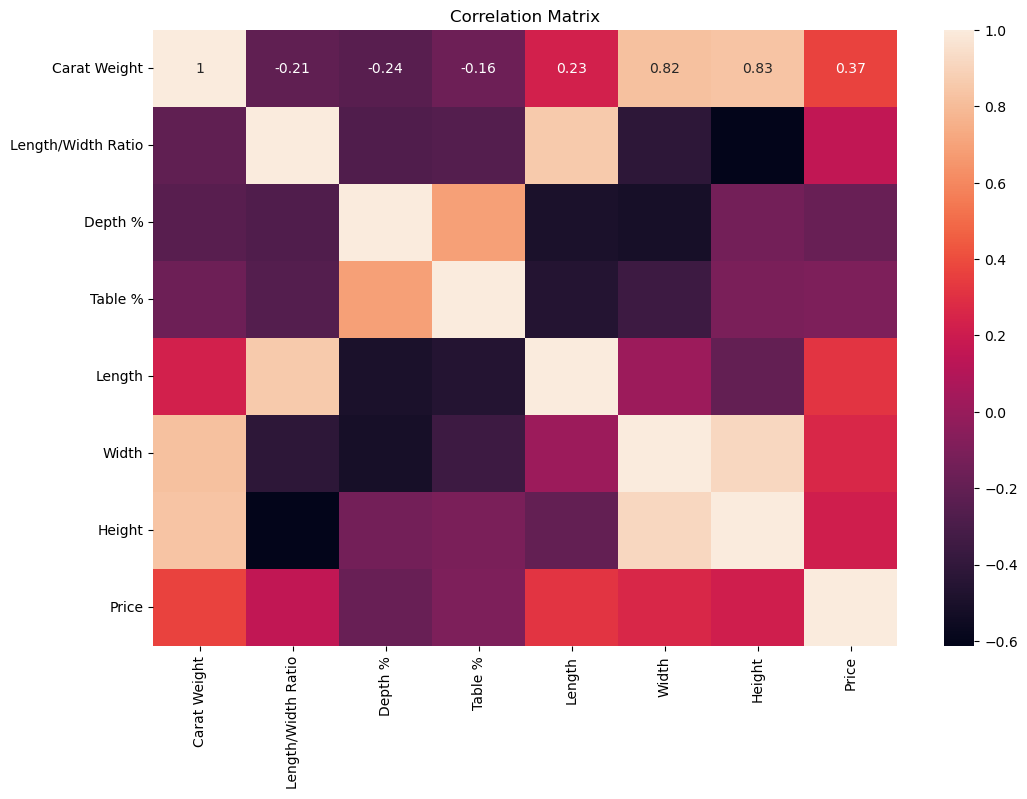

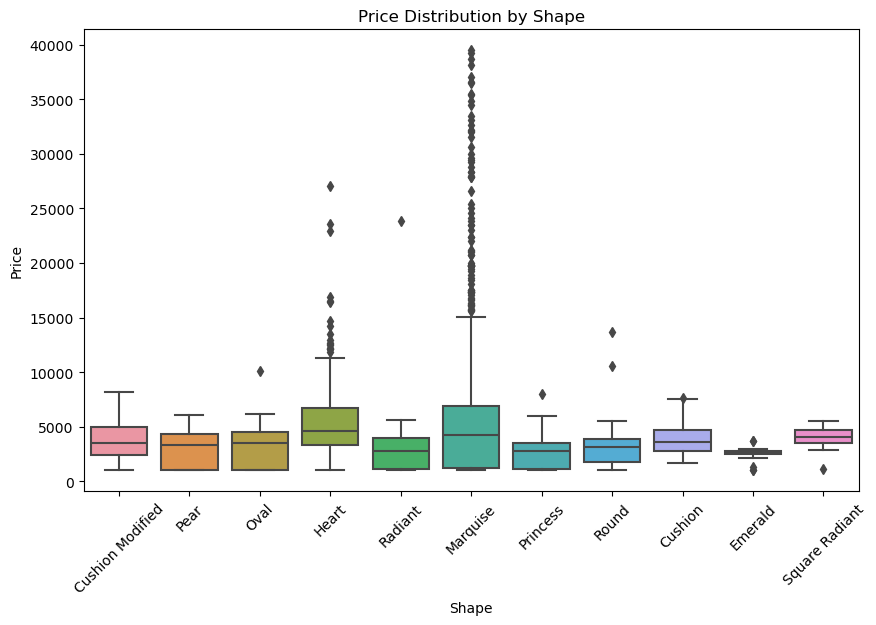

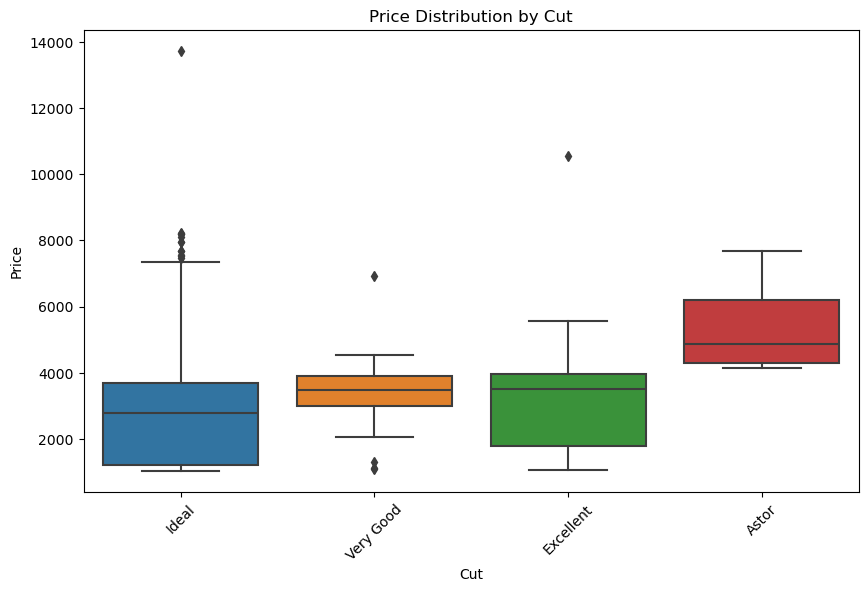

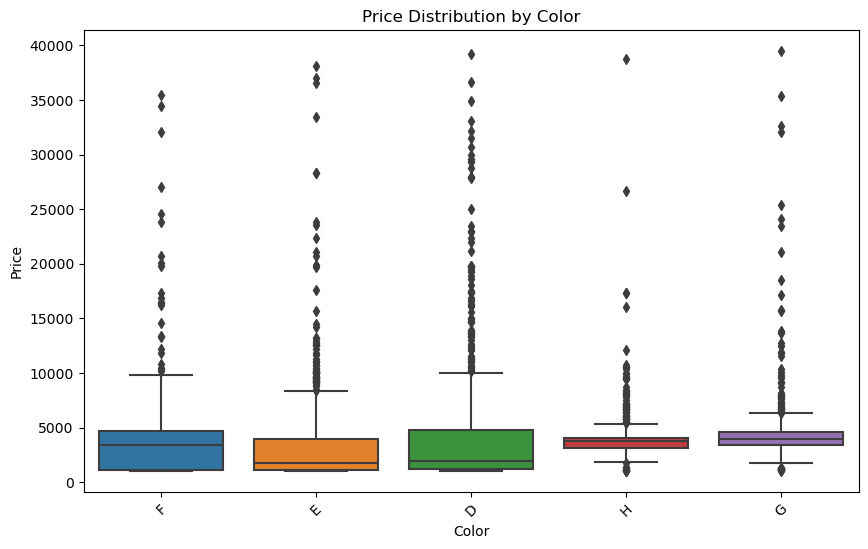

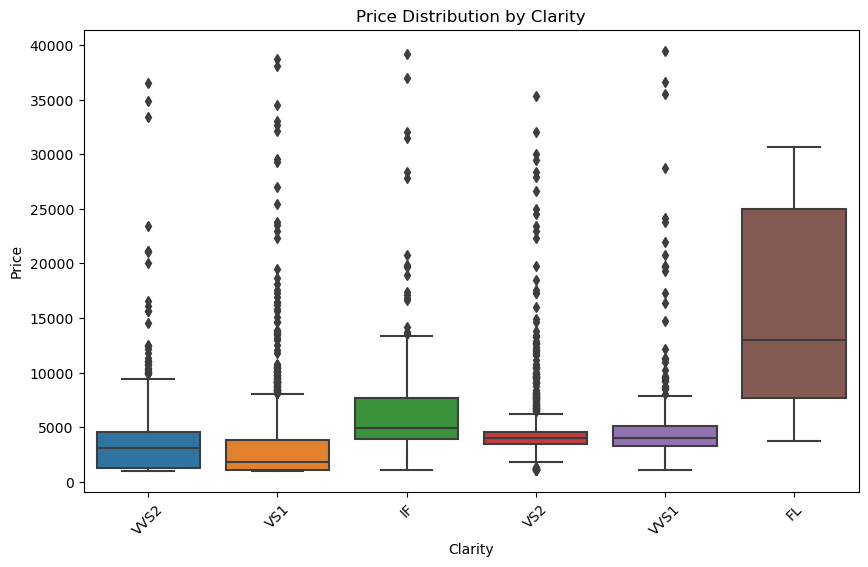

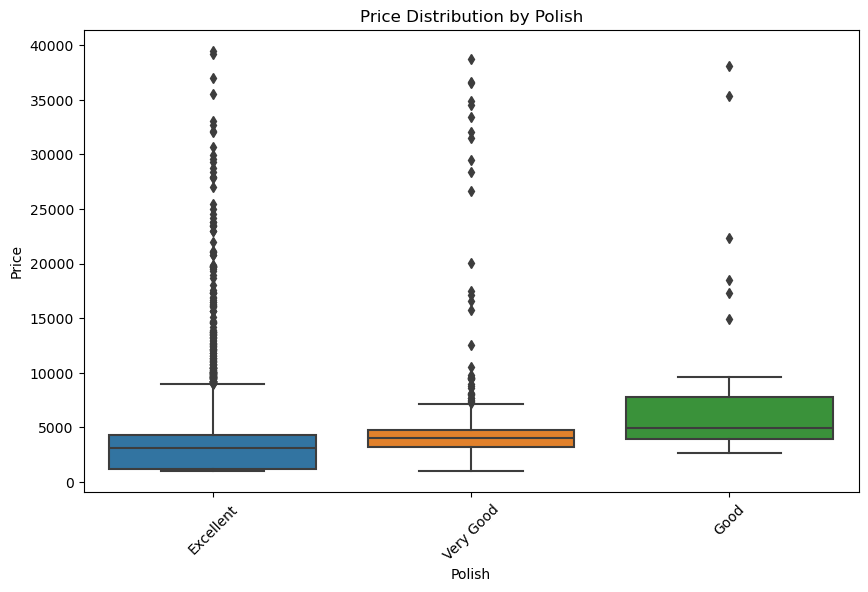

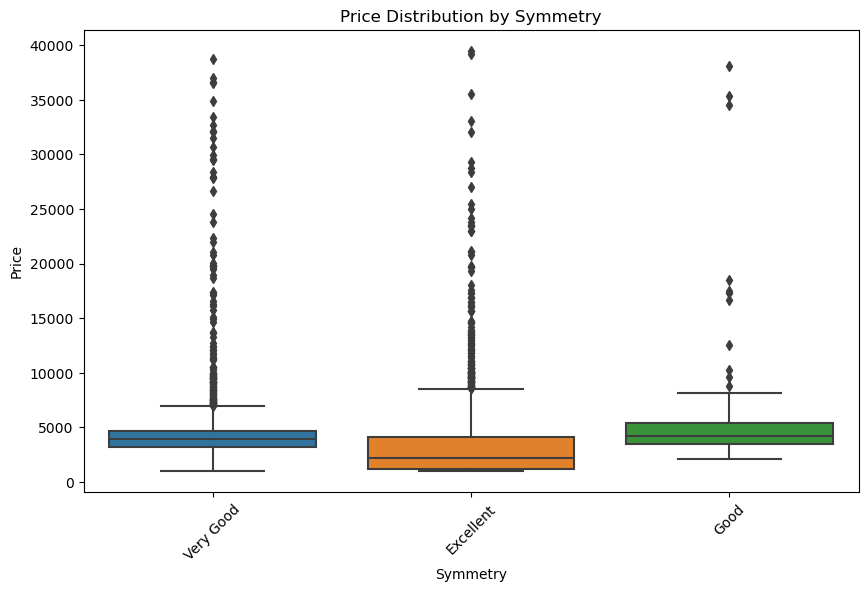

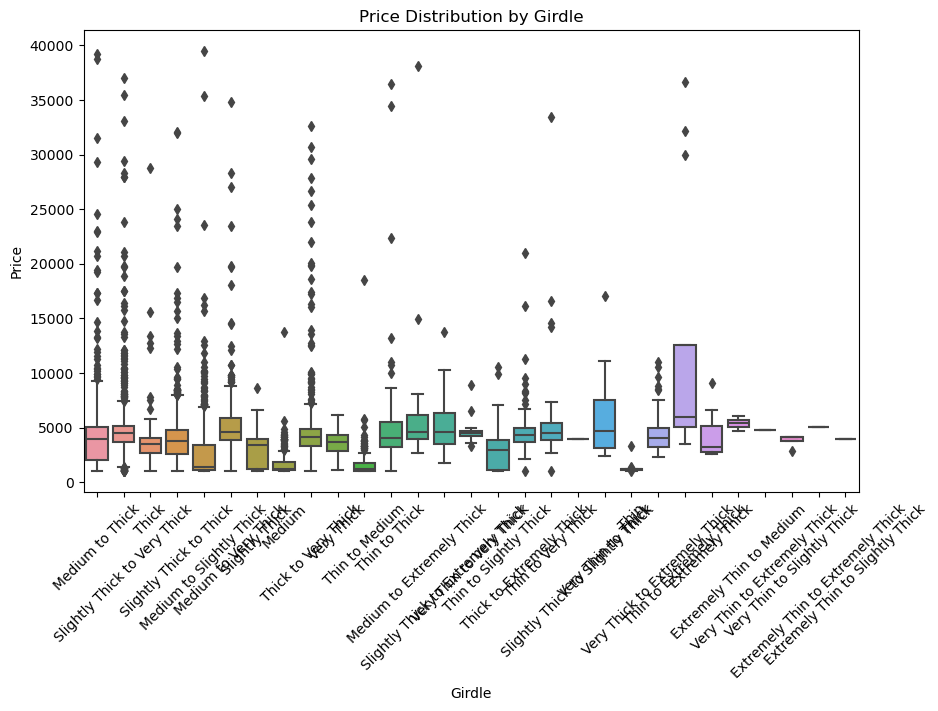

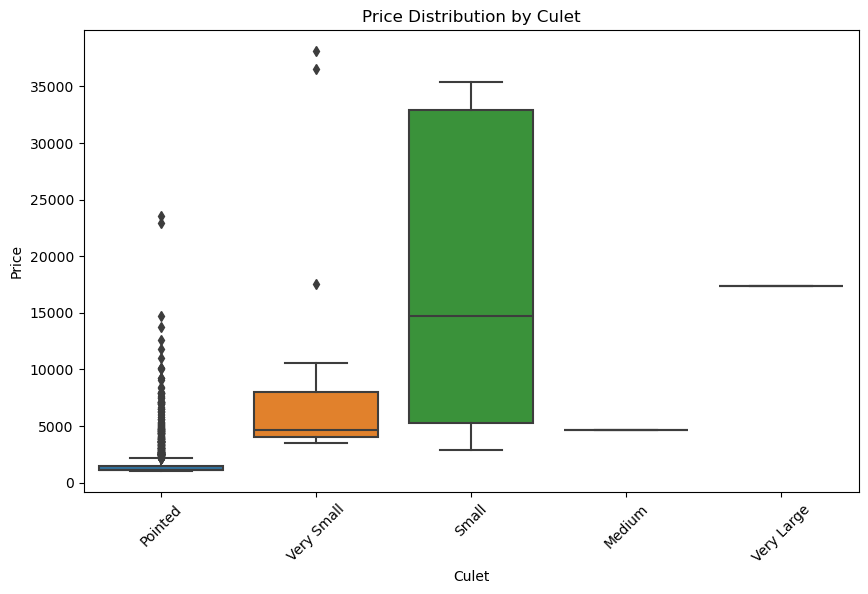

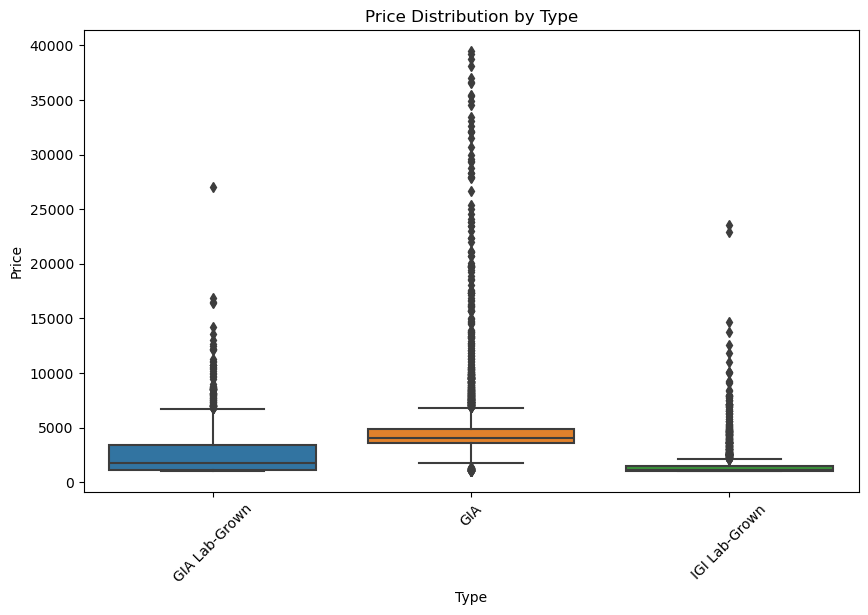

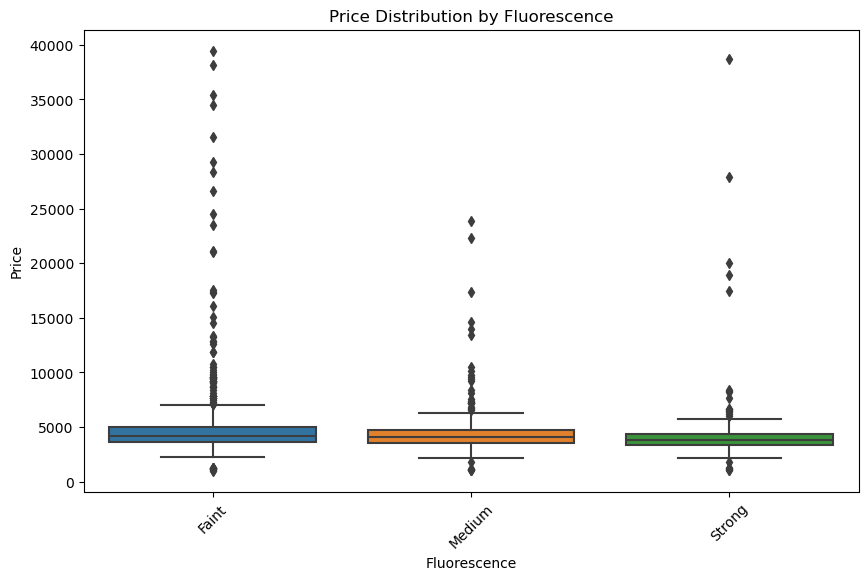

In [17]:
# Load and explore data
df = predictor.load_and_explore_data("C:\\Users\\MY\\Downloads\\diamonds.csv")

In [19]:
x, y = predictor.preprocess_data()

In [21]:
# Perform feature selection
X_selected = predictor.perform_feature_selection()

Selected features: Index(['Shape', 'Carat Weight', 'Symmetry', 'Girdle', 'Length', 'Width',
       'Height', 'Type', 'Volume', 'Price_per_carat'],
      dtype='object')


In [23]:
# Train models
results = predictor.train_models()


Training Linear Regression...

Training Random Forest...
Best parameters: {'max_depth': 10, 'n_estimators': 100}

Training XGBoost...
Best parameters: {'max_depth': 3, 'n_estimators': 100}

Training SVR...
Best parameters: {'C': 10, 'kernel': 'linear'}

Training KNN...
Best parameters: {'n_neighbors': 5, 'weights': 'distance'}


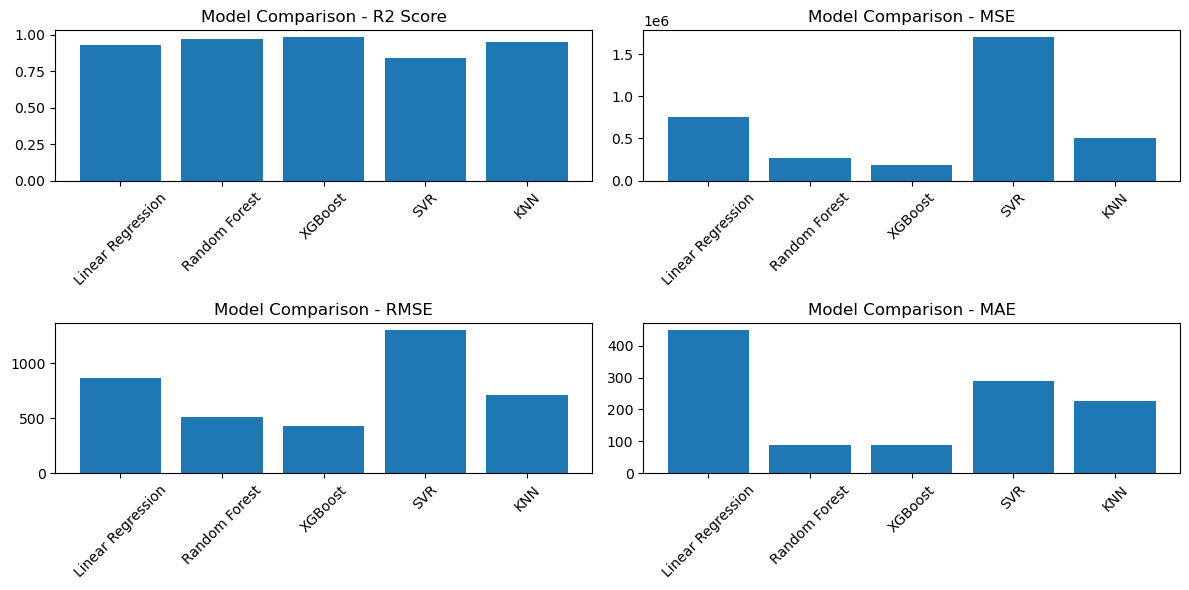

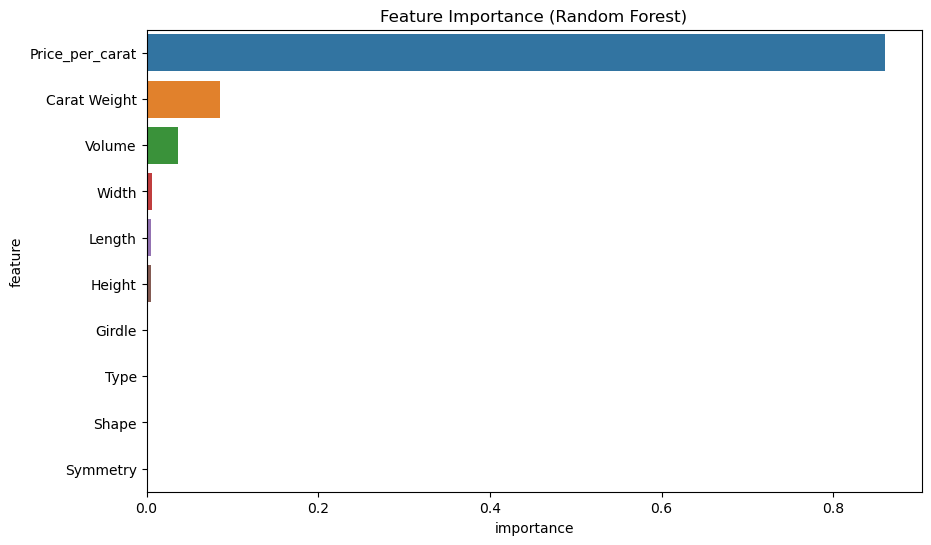

In [27]:
# Evaluate models
predictor.evaluate_models()

In [29]:
# Save models
predictor.save_models()

In [33]:
# Create web app
predictor.create_web_app()